In [1]:
%pylab inline
import GPy
from scipy.io import wavfile as wav

figsize(15, 5)

Populating the interactive namespace from numpy and matplotlib


# Data

Note the following:

- Normalize data `x`to lie between -1 and 1
- Take the unit of time `t` to be msec

Both are commonly used scales in the audio world.

Apart from being convenient (i.e. all the relevant quantities will be of order 1), these scales are also practically important. Why?

1. Default settings of GPs are often `1.`, so you want the number one to *mean* something relevant
2. We work on discrete computers, not idealized continuous math, so our computations will be most precise if we stick in general to quantities of order 1

In [2]:
rate, data = wav.read('3-notes.wav')
data = data/amax(abs(data))
data -= mean(data) # Remove inaudible DC component (i.e., the mean)
print('Data mean =', mean(data))

x = data[:,0]
t = arange(len(x))*1000./rate

Data mean = 2.8926513961913258e-18


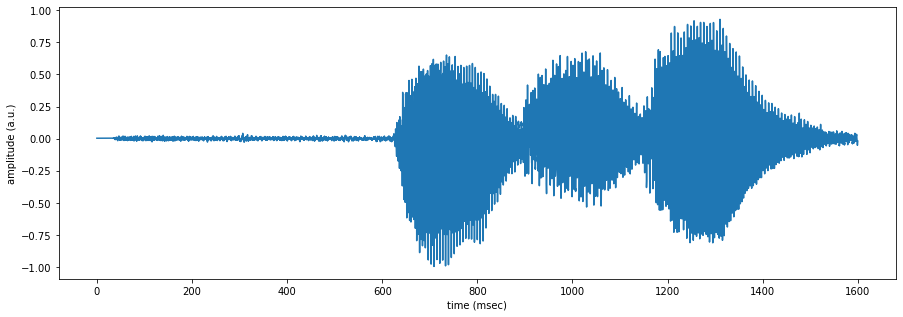

In [3]:
plot(t, x)
xlabel('time (msec)'); ylabel('amplitude (a.u.)');

In [4]:
first_note = x[6100:6500]
second_note = x[7800:8200]
third_note = x[10000:10400]

full_t = linspace(0, 400*1000./rate, 400) # msec
full_x = first_note
del second_note
del third_note

train_t = concatenate((full_t[:200], full_t[300:]))
train_x = concatenate((full_x[:200], full_x[300:]))
test_t = full_t[200:300]
test_x = full_x[200:300]

# Add annoying singleton dimensions for use in GPy
full_T = full_t[:,None]
full_X = full_x[:,None]
train_T = train_t[:,None]
train_X = train_x[:,None]
test_T = test_t[:,None]
test_X = test_x[:,None]

## Looking at the data

Acquire prior information to use in the GPs, both in time and spectral domain. The harmonic structure is clearly visible in the spectrum.

The practical use of prior information is to constrain the optimization and make it more likely to produce something we like, i.e. the model's predictions should exhibit properties we already know to be true.

Here we calculate

1. Test data variance
2. The dominant frequency `fmax` present in the full data (i.e. with maximum power). In this particular case, the fundamental frequency `f0` is *not* the dominant one; rather, the first harmonic is (`fmax = 2*f0`). If you look closely at the waveform, you can see that each fundamental period exists of two nearly identical subperiods of the same length, of which one has an extra sharp wiggle added. This detail is accordingly reflected in the spectrum.

We then use these values below to set the starting guesses for the GP parameters.

Notes for point (2):

- By calculating it from `full_x` we are cheating because we look at the training data. Instead, we should calculate the dominant frequencies present in the left and right part of the training data (**not the concatenated training data**) and average them. But in this particular toy problem we choose to take this shortcut.

- Usually `f0` is the dominant frequency, so this data is unusual in that respect. Because the first harmonic `fmax` is so strong, humans may or may not perceive the pitch of this audio fragment to be `2f0` rather than `f0`. I add for completeness that for this reason sometimes the fundamental frequency is redefined to be the first harmonic and the fundamental frequency is then redefined as the first *subharmonic*.

Standard deviation of the data (a.u.) = 0.4135955264142795
Dominant frequency component (Hz) = 320.0
Corresponding period (msec) =  3.125


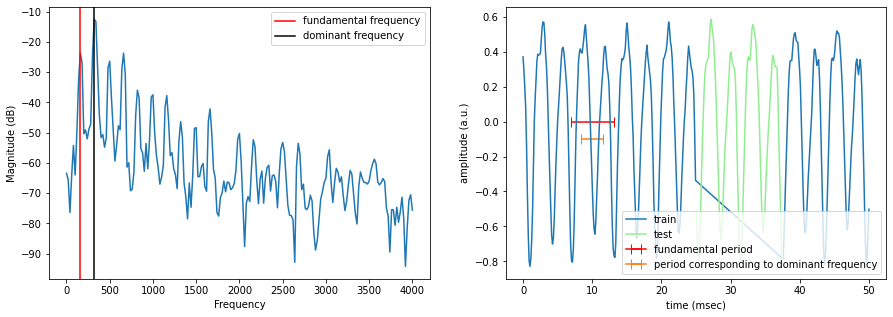

In [5]:
var_x = var(train_x)
std_x = sqrt(var_x)
print('Standard deviation of the data (a.u.) =', std_x)

subplot(121)
spectrum, freqs, _ = magnitude_spectrum(full_x, Fs=rate, scale='dB')

# Find and annotate dominant frequency component (largest peak in the spectrum)
fmax = freqs[argmax(spectrum)] # Hz
f0 = fmax/2 # Hz
Tmax = 1000./fmax # msec
T0 = Tmax*2 # msec

axvline(x=f0, label='fundamental frequency', color='red')
axvline(x=fmax, label='dominant frequency', color='black')
legend()

subplot(122)
plot(train_t, train_x, '-', label='train')
plot(test_t, test_x, '-', label='test', color='lightgreen')
errorbar(10, 0, xerr=T0/2, capsize=5, label='fundamental period', color='red')
errorbar(10, -.1, xerr=Tmax/2, capsize=5, label='period corresponding to dominant frequency')
xlabel('time (msec)'); ylabel('amplitude (a.u.)')
legend()

print('Dominant frequency component (Hz) =', fmax)
print(f'Corresponding period (msec) = ', Tmax)

# Inference

## RBF kernel

GPy's RBF agrees with Rasmussen & Williams (2006, 83):

$$
k(r) = \sigma^2 \exp -\frac{1}{2} \frac{r^2}{\ell^2}
$$

where $r = |x - x'|$. We also add observation noise with variance $\sigma_0^2$.

### Vanilla kernel (not optimized, just guesses for hyperparameters)

What are sensible guesses for the hyperparameters $\sigma_0^2$, $\sigma^2$ and $\ell$?

- $\sigma_0^2$ regulates the balance between data fit and giving freedom to the model. We believe that the data contains almost no noise, i.e. our model should capture all significant properties of the data (in our case this means capturing the dominant frequency with some slow amplitude modulation). So we set $\sigma_0^2$ to a small value. The usual way of expressing the strength of the noise relative to the data is by means of [SNR](https://en.wikipedia.org/wiki/Signal-to-noise_ratio) (signal-to-noise ratio), where the signal and noise power are measured typically by their variance. A SNR of 1 (or, equivalently, 0 dB) is a very dirty signal, where "noise and signal are equally powerful". SNRs over 20 dB are considered signals with small noise, though the noise is easily discernible by humans in audio context in vanilla applications. (The dynamic range of the human auditory system is 130 dB.) For reference, a SNR of 20 dB is the baseline achieved by linear models of quasi-periodic signals such as voiced speech. For example, the encoders and decoders used in Skype and Whatsapp will use models which can achieve SNRs >= 25 dB.

- For $\sigma^2$ we just take the data variance.

- For $\ell$ we need to think harder. It is the characteristic lengthscale, but what does this mean? One way of understanding this is in terms of how many times the function wiggles (changes direction) around the mean, since we expect that the function stays smooth (i.e. doesn't change direction abruptly) in an interval approximately the size of $\ell$. This is quantified by the expected number of zero upcrossings (EZUP). You can see how this then correlatess with oscillations around zero, which in turn correlates with the dominant frequency. These are mere correlations, not implications, but suffice for guessing starting values for the optimization.

  Read Rasmussen & Williams (2006, 83) for more about EZUP and $\ell$.

#### Sampling from vanilla kernel

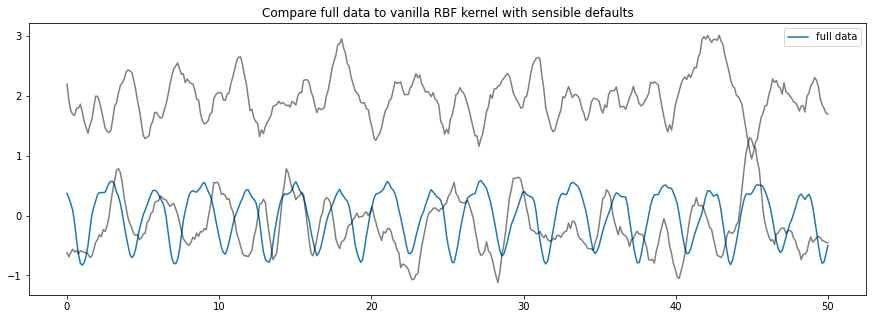

In [6]:
def SNR_to_noise_power(signal_power, SNR_dB):
    """
    Solve the SNR formula
    
        SNR_dB = 10 log10[signal_power/noise_power]
    
    for noise_power.
    """
    noise_power = signal_power*10.**(-SNR_dB/10.)
    return noise_power

SNR = 20 # dB
noise_var = SNR_to_noise_power(var_x, SNR)

# Derive lengthscale from expected number of zero upcrossings in unit interval (1 msec)
# We derive the number of zero upcrossings per msec from the dominant frequency component
# Formula from Rasmussen & Williams (2006, 83)
ell_guess = Tmax/(2*pi)

k1 = GPy.kern.GridRBF(1, variance=var_x, lengthscale=ell_guess)
k2 = GPy.kern.White(1, variance=noise_var)
k = k1 + k2

cov = k.K(full_T)

title('Compare full data to vanilla RBF kernel with sensible defaults')
plot(full_t, full_x, label='full data')
legend()
n = 2
for i in range(n):
    x0 = multivariate_normal(full_t*0., cov)
    plot(full_t, 2*i + x0, alpha=1/n, color='black')

#### Sampling from vanilla kernel **conditioned on the training data**

Equivalent SNR over full data (dB) = [20.]
SNR at test data (dB) = 0.7036528660833096


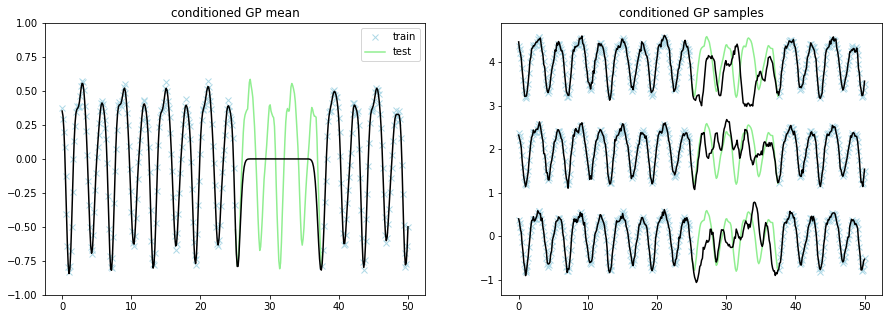

In [7]:
# Note: GPRegression() automatically adds observation noise (our k2 above) for reasons of numerical
# stability. So we supply only the RBF kernel to this function
m = GPy.models.GPRegression(train_T, train_X, k1, noise_var=noise_var)

%run display_m.ipy

### Optimize

GP has no predictive power and reverts to 0. We have just overfitted the training data.

Equivalent mean zero upcrossing rate (Hz) = [448.29926385]
Equivalent SNR over full data (dB) = [31.7315998]
SNR at test data (dB) = 0.9818398365806518


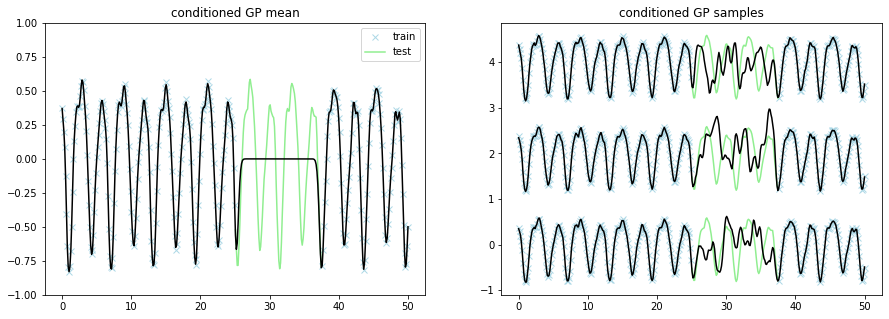

In [8]:
m.optimize(messages=True)

zero_crossing_rate_per_msec = 1/(m.gridRBF.lengthscale*2*pi) # Rasmussen & Williams (2006, 83)
print('Equivalent mean zero upcrossing rate (Hz) =', 1000./(m.gridRBF.lengthscale*2*pi))

%run display_m.ipy

## Standard periodic kernel

The standard periodic kernel is a periodic RBF kernel, i.e. the periods are modeled by a RBF kernel. 

GPy's standard periodic kernel in 1D for period $\lambda$:

$$
k(r) = \sigma^2 \exp \left[  - \frac{1}{2} \frac{\sin^2(\frac{\pi}{\lambda} r )}{\ell^2} \right]
$$

where $r = |x - x'|$. Note about the formula: the function $\sin(\pi r/\lambda)$ has period $T=\lambda/2$. The function $\sin^2(\pi r/\lambda)$ has period $T=\lambda$.

Parameter guesses:

- $\sigma^2$: as before

- $\lambda$: Now we take the period to be `T0`, the fundamental frequency, because we hope that the wiggle can be modeled by the underlying RBF kernel controlled by parameters $\sigma^2$ and $\ell$.

- $\ell$: We can use the same reasoning as before. The expected number of zero upcrossings EZUP by the RBF kernel sample during one period $\lambda$ is $\text{EZUP}=\lambda/(2\pi\ell)$. Normally we would not like to have periodical behavior within the fundamental period, so we would set EZUP to one, such that $\ell_\text{normal} = \lambda/2\pi$. But our data is special, because we have a dominant first harmonic. So we know that there is a strong subperiod during one $\lambda$, such that EZUP = 2. This gives $\ell_\text{subharmonic} = \lambda/4\pi$.

  Note that the value of $\ell$ is robust to change, and using $\ell_\text{normal}$ should be fine. Below we use $\ell_\text{subharmonic}$ to see the effect it has on GP samples.

### Sampling from vanilla kernel with parameter guesses

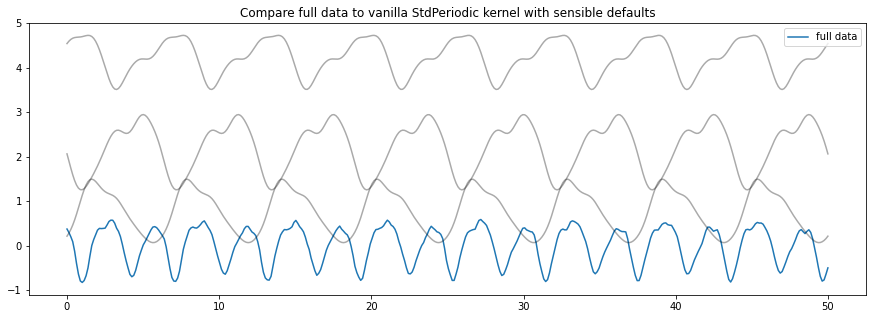

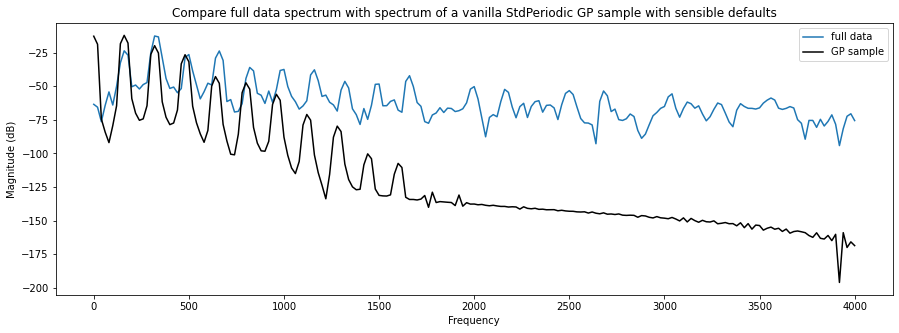

In [9]:
ell_period_guess = T0/(4*pi)

k = GPy.kern.StdPeriodic(1, variance = var_x, period=T0, lengthscale=ell_period_guess)

cov = k.K(full_T)

title('Compare full data to vanilla StdPeriodic kernel with sensible defaults')
plot(full_t, full_x, label='full data')
legend()
n = 3
for i in range(n):
    x0 = multivariate_normal(full_t*0., cov)
    plot(full_t, 2*i + x0, alpha=1/n, color='black')

show()

title('Compare full data spectrum with spectrum of a vanilla StdPeriodic GP sample with sensible defaults')
magnitude_spectrum(full_x, rate, scale='dB', label='full data')
magnitude_spectrum(x0, rate, scale='dB', color='black', label='GP sample')
legend();

### Optimize

Equivalent SNR over full data (dB) = [22.88907347]
SNR at test data (dB) = 23.739223906924657


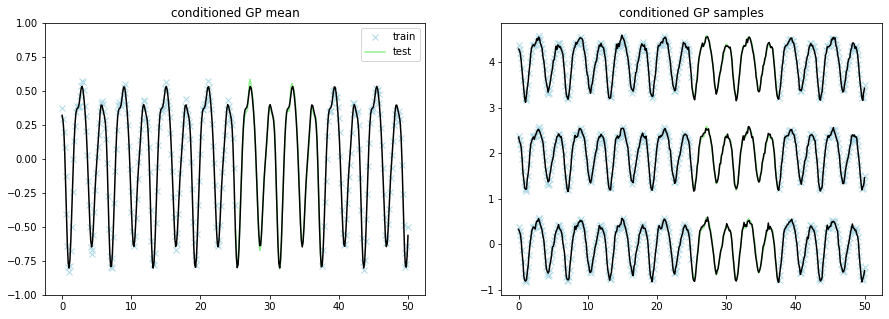

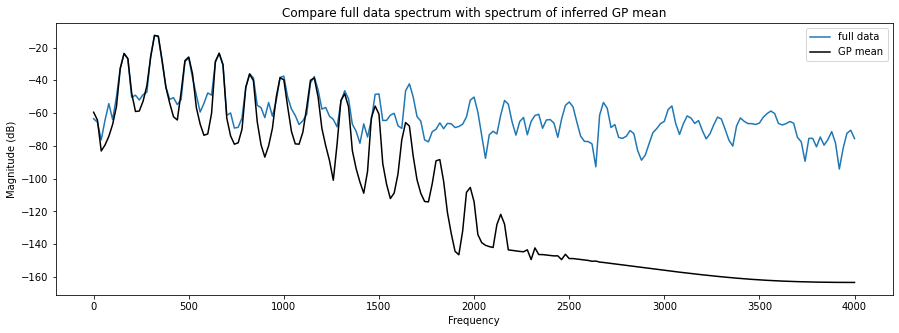

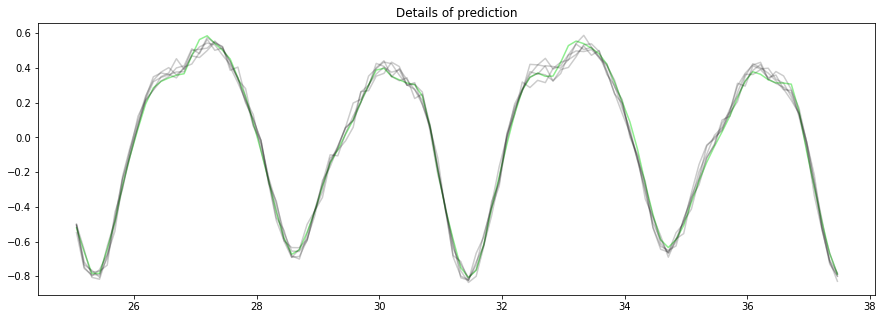

In [10]:
m = GPy.models.GPRegression(train_T, train_X, k, noise_var=noise_var)
m.optimize(messages=True)

%run display_m.ipy

xmean, cov = m.predict(full_T, full_cov=True)

title('Compare full data spectrum with spectrum of inferred GP mean')
magnitude_spectrum(full_x, rate, scale='dB', label='full data')
magnitude_spectrum(xmean[:,0], rate, scale='dB', color='black', label='GP mean')
legend()
show()

title('Details of prediction')
xmean, cov = m.predict(test_T, full_cov=True)
plot(test_t, test_x, color='lightgreen')
n = 5
for i in range(n):
    x0 = multivariate_normal(xmean[:,0], cov)
    plot(test_t, x0, alpha=1/n, color='black')

show()

## Standard periodic kernel whose amplitude is modulated by an RBF

We can get slightly better performance by modulating the whole signal by a RBF with a very long lengthscale (i.e. very slow modulation). Our guess for this lengthscale $\ell_\text{modulator}$ is 50 times that of the lengthscale associated with the fundamental frequency of the signal.

To encode that $\ell_\text{modulator}$ represents large-scale modulation and should not interfere with the short-scale frequency components of the signal, we could for example put a Gaussian prior on it, $p(\ell_\text{modulator}) = \mathcal{N}(\mu=100, \sigma=10)$, or do other smarter things.

Equivalent SNR over full data (dB) = [29.24134099]
SNR at test data (dB) = 24.578439789477166


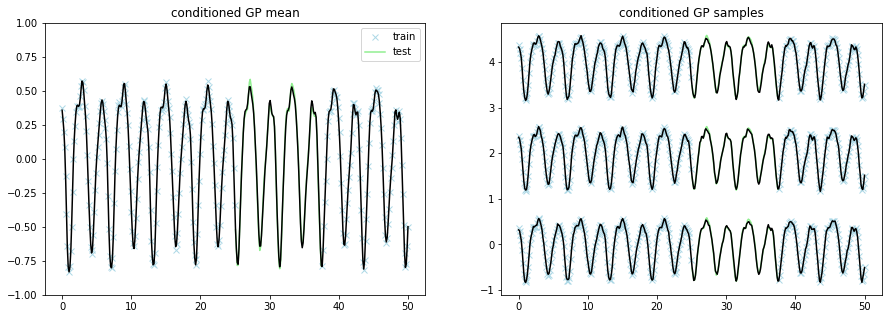

In [11]:
ell_guess_modulator = 50*T0/(2*pi)

k1 = GPy.kern.GridRBF(1, variance = var_x, lengthscale=ell_guess_modulator)

k2 = GPy.kern.StdPeriodic(1, variance = 1., period=T0, lengthscale=ell_period_guess)
k2.variance.fix() # Since k1 controls the variance, we can save computation and set this to one

k = k1*k2

m = GPy.models.GPRegression(train_T, train_X, k, noise_var=noise_var)
m.optimize(messages=True)

%run display_m.ipy

# Discussion

- We didn't underestimate complexity of the data, we underestimated the complexity of the optimize landscape: we need to be close to the global maximum!

- Sensible defaults matter

- That global maximum does correspond with what we want for simple models, so the GPs don't fail us, it's just that we need to optimize them better

- Various ways of doing this :

  1. Extract guesses automatically from data (here)
  
  2. Use prior distributions on the parameters, e.g. Gaussians, and do MAP optimization instead of ML optimization
  
  3. Use different optimizing strategy (e.g. global minimum search routines)
  
  4. Use more complex models which are more tolerant to lazy initial guesses
  
  I'd say points 1, 2 and 4 are crucial.